In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:
%matplotlib notebook

In [3]:
!pip install matplotlib_venn

    100% |████████████████████████████████| 40kB 4.5MB/s ta 0:00:011
  Running setup.py bdist_wheel for matplotlib-venn ... done
  Stored in directory: /home/julianarhee/.cache/pip/wheels/d8/88/2f/e41518cb16e58109e8d14dc5dd7ef8166c82dce86c7c6d6c80
Successfully built matplotlib-venn
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Select datasets

In [4]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [53]:
reload(util)

<module 'pipeline.python.classifications.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py'>

In [5]:
#del S
S = util.Session(animalid, session, fov, rootdir=rootdir)

[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
Found epi sessions: []
No EPI maps found for session: %s * (trying to use tmp session boundaries file)
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC084/epi_maps/screen_boundaries_tmp.json'])
*********************************
{   'azimuth': 117.5584,
    'bb_left': -58.7792,
    'bb_lower': -33.6615,
    'bb_right': 58.7792,
    'bb_upper': 33.6615,
    'elevation': 67.323,
    'resolution': [1024, 768]}
*********************************
('center 2 Top/Anterior:', 33.6615, 58.7792)


In [6]:
S.load_data(traceid=traceid, trace_type='corrected')

Loading data: traces001 - corrected
[rfs] creating experiment object.
... [combined_rfs_static] getting data path.
... renaming experiment to run name: combined_rfs_static
... loading data array (combined_rfs_static - datasets.npz)
[gratings] creating experiment object.
... [combined_gratings_static] getting data path.
... [mean_Slice01_Channel01_File001_gratings1.png] getting data path.
... no data arrays found for: mean_Slice01_Channel01_File001_gratings1.png
... [max_std_Slice01_Channel01_gratings.png] getting data path.
... no data arrays found for: max_std_Slice01_Channel01_gratings.png
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
[blobs] creating experiment object.
... [combined_blobs_static] getting data path.
... renaming experiment to run name: combined_blobs_static
... loading data array (combined_blobs_static - datasets.npz)
[retino] creating experiment object.
... [retino_run1] getting data pa

In [7]:
S.experiments.keys()

['rfs', 'gratings', 'blobs', 'retino']

In [7]:
# excluded_params = ['position']
# exp = S.experiments['rfs']
# all_params = [c for c in exp.data.sdf.columns if c not in excluded_params]
# tested_params = [c for c in all_params if len(exp.data.sdf[c].unique()) > 1]
# stim_params = dict((str(p), sorted(exp.data.sdf[p].unique())) for p in tested_params)
# stim_params
        

# Get list of "responsive cells" for each experiment

In [28]:
responsive_test = 'ROC'

mag_ratio_thr = 0.01
rf_fit_thr = 0.5

roi_lists={}
exp_gdfs={}
for exp_name, exp in S.experiments.items():
    if exp_name == 'blobs':
        continue
        
    print("[%s] Loading roi lists..." % exp_name)
    curr_roi_list = []
    
    # Load data:
    exp.data.traces, exp.data.labels = util.check_counts_per_condition(exp.data.traces, exp.data.labels)

    # Load list of "visually responsive" cells
    if exp_name in ['gratings', 'blobs']:
        curr_base_dir = exp.source.split('/data_arrays/')[0]
        try:
            curr_stats_dir = os.path.join(curr_base_dir, 'summary_stats', responsive_test)
            stats_fpath = glob.glob(os.path.join(curr_stats_dir, '*results*.pkl'))
            assert len(stats_fpath) > 0, "No stats results found for: %s" % curr_stats_dir
            with open(stats_fpath[0], 'rb') as f:
                roistats = pkl.load(f)
            curr_roi_list = [r for r, res in roistats.items() if res['pval'] < 0.05]
        except Exception as e:
            print e
            print("-- Unable to load stats: %s [%s]" % (responsive_test, exp_name))
    else:
        if exp_name == 'rfs':
            try:
                rf_fits = sorted(glob.glob(os.path.join(S.experiments['rfs'].source.split('/data_arrays/')[0],
                                                 'figures', 'receptive_fields', 'rfs_2dgaus*', '*.pkl')), key=natural_keys)
                if len(rf_fits) > 1:
                    for r, ri in enumerate(rf_fits):
                        print(r, ri)
                    sel = input("-- Select IDX of fits to use: ")
                    rfs_fpath = rf_fits[int(sel)]
                else:
                    rfs_fpath = rf_fits[0]
                with open(rfs_fpath, 'rb') as f:
                    rffits = pkl.load(f)
                curr_roi_list = [r for r, res in rffits['fits'].items() if res['fit_r']['r2'] >= rf_fit_thr]
            except Exception as e:
                print e
                print("-- No RF fits! [%s]" % exp_name)
        elif 'retino' in exp_name:
            #print("-- Not implemented -- [%s]" % exp_name)
            magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])
            curr_roi_list = [r for r in magratios.index.tolist() if any(magratios.loc[r] > mag_ratio_thr)]

    roi_lists[exp_name] = curr_roi_list
    
    if 'retino' not in exp_name:
        exp.load(trace_type='dff')
        exp_gdfs[exp_name] = resp.group_roidata_stimresponse(exp.data.traces[curr_roi_list], exp.data.labels)
    else:
        exp_gdfs[exp_name] = magratios.max(axis=1)
        

[rfs] Loading roi lists...
... loading data array (combined_rfs_static - datasets.npz)
[gratings] Loading roi lists...
... loading data array (combined_gratings_static - datasets.npz)
[retino] Loading roi lists...
[-22.31640161 -22.29640484 -22.27640806 ...,  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


#### Compare rois

In [11]:
for exp_name, rlist in roi_lists.items():
    print('%s: %i rois' % (exp_name, len(rlist)))

rfs: 64 rois
gratings: 124 rois
retino: 132 rois


In [72]:
import itertools

tmp_roi_list = [v for k, v in roi_lists.items()]
all_rois = list(set(itertools.chain(*tmp_roi_list)))


In [77]:
from matplotlib_venn import venn3, venn3_circles


In [98]:
v.get_patch_by_id('A')

['rfs', 'gratings', 'retino']


<IPython.core.display.Javascript object>


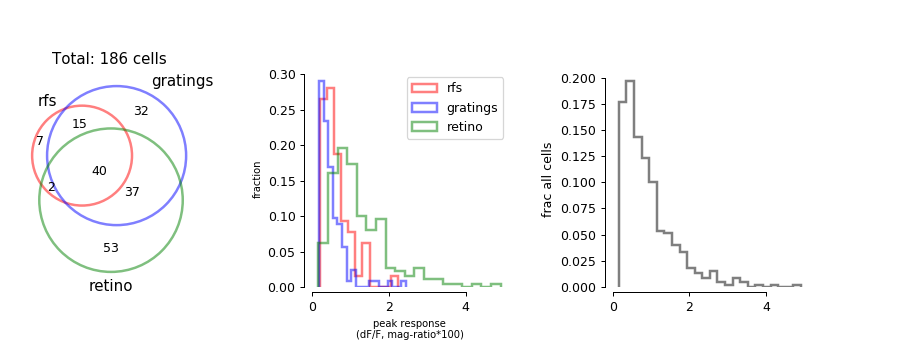

In [112]:
roi_sets = [set(rlist) for k, rlist in roi_lists.items()]
roi_set_labels = [k for k, rlist in roi_lists.items()]
print(roi_set_labels)

exp_colors= {'rfs': 'red',
            'gratings': 'blue',
            'retino': 'green'}

fig, axes = pl.subplots(1,3, figsize=(10,4))

ax = axes[0]
v = venn3(roi_sets, set_labels=roi_set_labels, ax=ax)
# for pid, ename in zip(['A', 'B', 'C'], roi_set_labels):
#     #v.get_patch_by_id(pid).set_color(exp_colors[ename])
#     v.get_patch_by_id(pid).set_alpha(0)
for pid in v.id2idx.keys():
    #v.get_patch_by_id(pid).set_color(exp_colors[ename])
    v.get_patch_by_id(pid).set_alpha(0)

c=venn3_circles(roi_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
for ci in range(len(c)):
    c[ci].set_edgecolor(exp_colors[roi_set_labels[ci]])
    c[ci].set_alpha(0.5)
    
ax.set_title('Total: %i cells' % len(all_rois))
#v.get_patch_by_id('rfs').set_color('black')


ax = axes[1]
for ename, gdf in exp_gdfs.items():
    if 'retino' in ename:
        peak_values = exp_gdfs[ename].values * 100.
    else:
        peak_values = exp_gdfs[ename].max()['meanstim'].values
    weights = np.ones_like(peak_values) / float(len(peak_values))
    sns.distplot(peak_values, label=ename, ax=ax, norm_hist=0, kde=False,
                 rug=False, rug_kws={"alpha": 0.5},
                 hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.5,
                         'weights': weights, 'normed': 0, "color": exp_colors[ename]})
    
ax.set_xlabel('peak response\n(dF/F, mag-ratio*100)', fontsize=8)
ax.set_ylabel('fraction', fontsize=8)
ax.legend()
sns.despine(trim=True, offset=4, ax=ax)


ax = axes[2]
all_values = []
for ename, gdf in exp_gdfs.items():
    if 'retino' in ename:
        all_values.extend( gdf.values * 100.)
    else:
        all_values.extend(gdf.max()['meanstim'].values)
weights = np.ones_like(all_values) / float(len(all_values))
sns.distplot(all_values, ax=ax, norm_hist=0, kde=False,
            rug=False,
            hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.5,
                         'weights': weights, 'normed': 0, "color": 'k'}) #[ename]})
sns.despine(trim=True, offset=4, ax=ax)
ax.set_ylabel('frac all cells')

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.01, bottom=0.2)

In [49]:
 exp_gdfs['retino'].values * 100.

array([ 0.88996608,  0.86813714,  1.08794085,  0.85355084,  0.70886394,
        1.40744733,  0.35805293,  0.28081369,  0.27756649,  0.89238255,
        0.46128487,  2.53571158,  0.77883545,  0.73777441,  3.15452774,
        1.21749055,  0.4170593 ,  2.65934975,  0.8829117 ,  1.15452034,
        0.99523448,  1.14828053,  0.16047576,  1.27139539,  1.11029143,
        1.8662067 ,  0.88213584,  0.98723926,  2.04289941,  0.42008391,
        0.45632942,  0.74832048,  0.47797491,  0.81784351,  0.68261278,
        1.00498487,  0.54912267,  0.53054481,  1.37166833,  1.29636964,
        2.25504154,  0.84807677,  0.62975441,  0.72830759,  0.95581397,
        1.84782859,  0.49875785,  0.27222224,  3.27551975,  1.32024383,
        0.78251006,  0.68035734,  0.46429783,  0.8610309 ,  1.90763612,
        1.65700063,  1.9671598 ,  1.87409108,  1.80266291,  1.76235383,
        1.07745631,  1.04353367,  0.85967354,  1.23623686,  1.20436474,
        1.66207538,  3.44390344,  4.90545863,  1.43367896,  1.13

<IPython.core.display.Javascript object>


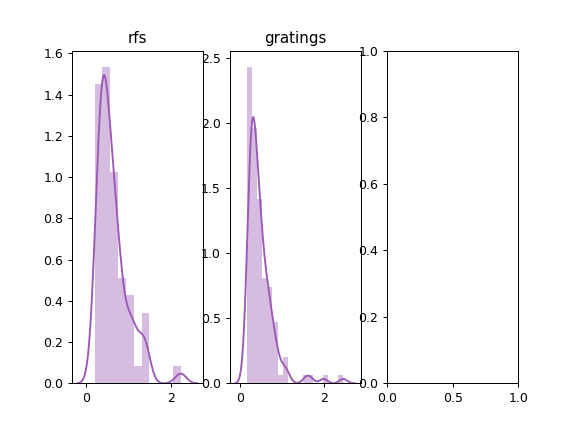

In [41]:
fig, axes = pl.subplots(1,3) #pl.figure()

for ename, ax in zip(exp_gdfs.keys(), axes.flat):
    if ename == 'retino':
        continue
    peak_values = exp_gdfs[ename].max()['meanstim'].values
    sns.distplot(peak_values, label=ename, ax=ax)
    ax.set_title(ename)

    

# Retino data

In [9]:

def do_retino_analysis_on_raw(exp):
    n_frames = exp.data.info['stimulus']['nframes']
    n_files = exp.data.info['ntiffs']
    fr = exp.data.info['stimulus']['frame_rate']
    stimfreq = exp.data.info['stimulus']['stimfreq']

    # label frequency bins
    freqs = np.fft.fftfreq(n_frames, float(1/fr))
    sorted_freq_ixs = np.argsort(freqs)
    freqs=freqs[sorted_freq_ixs]
    print(freqs)

    # exclude DC offset from data
    freqs=freqs[int(np.round(n_frames/2.))+1:]

    # Identify freq idx:
    stim_freq_ix=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
    top_freq_ix=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
    print("Target freq: %.3f Hz" % (freqs[stim_freq_ix]))
    

    trials_by_cond = exp.data.info['trials']
    trial_nums = np.array([v for k,v in trials_by_cond.items()])
    trial_nums = sorted(trial_nums.flatten())

    nframes_total, nrois = exp.data.traces.shape
    magratios=[]
    phases=[]
    conds=[]
    traces={}
    for curr_cond in trials_by_cond.keys():
        avg_traces = []
        for rid in exp.data.traces.columns:
            tracemat = pd.DataFrame(np.reshape(exp.data.traces[rid], (n_frames, n_files), order='F'),\
                                    columns=trial_nums)
            avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
            avg_traces.append(avg)
        avg_traces = pd.DataFrame(np.array(avg_traces).T, columns=exp.data.traces.columns)
        traces[curr_cond] = avg_traces

        magratio_array, phase_array = do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames)

        magratios.append(magratio_array)
        phases.append(phase_array)
        conds.append(curr_cond)
        
    magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
    phases = pd.DataFrame(np.array(phases).T, columns=conds)
    
    return magratios, phases, traces

def do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_freq_ixs]
    phase_data = phase_data[sorted_freq_ixs]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[stim_freq_ix, :]
    phase_array = phase_data[stim_freq_ix, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


In [79]:
magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])

[-22.31640161 -22.29640484 -22.27640806 ...,  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


#### Look at best cell

In [77]:
magratios[magratios['right'] == magratios.max()['right']]

,top,right,left,bottom
67,0.030328,0.049055,0.035195,0.045492


<IPython.core.display.Javascript object>


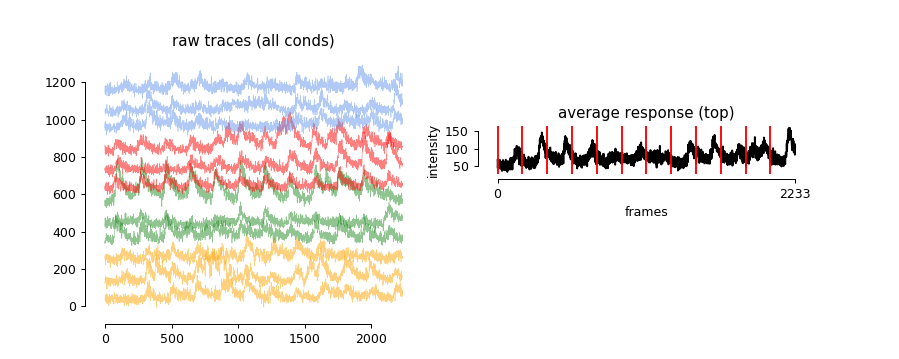

(2233,)


In [107]:
roi = 67

curr_cond = 'right' #max_mod_condn
n_frames = S.experiments['retino'].data.info['stimulus']['nframes']
n_files = S.experiments['retino'].data.info['ntiffs']
cycle_starts = S.experiments['retino'].data.info['stimulus']['cycle_start_ixs']

fig = pl.figure(figsize=(10,4))
gspec = gridspec.GridSpec(ncols=2, nrows=4, height_ratios=[1, 1, 1, 1])

# ax1 = fig.add_subplot(gspec[0, 0])
# ax1.imshow(np.reshape(S.experiments['retino'].data.traces[roi], cnm.dims, order='F'))
# ax1.set_title('rid %i' % rid)
# ax1.axis('off')

offset=100
trials_by_cond = S.experiments['retino'].data.info['trials']
colordict = {'right': 'forestgreen', 'left': 'orange',
            'top': 'cornflowerblue', 'bottom': 'red'}
ax2 = fig.add_subplot(gspec[:, 0])
tmat = np.reshape(S.experiments['retino'].data.traces[roi], (n_frames, n_files), order='F')
grouped_trials = copy.copy(trials_by_cond['left'])
for cond in ['right', 'bottom', 'top']:
    grouped_trials.extend(trials_by_cond[cond])
for ti, tnum in enumerate(grouped_trials): #range(tmat.shape[1]):
    curr_cond = [cond for cond, tlist in trials_by_cond.items() if tnum in tlist][0]
    curr_color = colordict[curr_cond]
    ax2.plot(tmat[:, tnum-1] + ti*offset, color=curr_color, alpha=0.5, lw=0.5)
ax2.set_title('raw traces (all conds)')

ax3 = fig.add_subplot(gspec[1, 1])
avg = traces[curr_cond][roi]
print(avg.shape)
ax3.plot(avg, 'k')
ax3.set_xticks([0, n_frames])
for cyc in cycle_starts:
    ax3.axvline(x=cyc, color='r')
ax3.set_title('average response (%s)' % curr_cond)
ax3.set_ylabel('intensity')
ax3.set_xlabel('frames')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.85, left=0.1, hspace=0.5)
#label_figure(fig, data_identifier)

In [113]:
magratios.loc[67]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64

In [114]:
magratio_thr = 0.01
retino_rois = [r for r in magratios.index.tolist() if any(magratios.loc[r] > magratio_thr)]
print(len(retino_rois))
                                                          

132


In [110]:
magratios.loc[roi]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64